### <mark>Setup paths</mark>

Launch ltspice docker
- cd ltspice_docker
- ./start.sh

In [7]:
# Add folder containing scripts to the path
import sys
sys.path.append('../') ## Change accordingly

# Command to execute LTSpice launch
LTSPICE_INSTANCE = "../../ltspice.sh" ## Change accordingly
HSPICE_INSTANCE = "../../hspice.sh" ## Change accordingly

In [8]:
# Store relative path from ltspice docker to current directory
import os
from pathlib import Path

ltspice_absolute = os.path.realpath(LTSPICE_INSTANCE)
ltspice_dir = os.path.dirname(ltspice_absolute)
notebook_dir = os.getcwd()

CURRENT_FOLDER = Path(notebook_dir).relative_to(ltspice_dir)
print("CURRENT_FOLDER:", CURRENT_FOLDER)

# Reload libraries automatically if is being changed on the fly
%load_ext autoreload
%autoreload 2

CURRENT_FOLDER: files/feedforward
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <mark>Runtime parameters</mark>


In [9]:
# Set R1 (middle) and R3 (right) to be 10x of memristor LRS (due to Kp ration)
thefile = str(CURRENT_FOLDER) + '/template/neuron_tanh_template.asc'
!$LTSPICE_INSTANCE $thefile

0038:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
0038:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
003a:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"
003a:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"


In [10]:
nn_layers = (4, 2, 3)
#nn_layers = (100, 50, 10)

CELL_PARAMETERS = {
    'states':    [100000, 10000], # Order from HRS to LRS
    'filename':  'cell_subcircuit',
    'tolerance': '0.05', # Tolerance of 5%
}

CBA1_PARAMETERS = {
    'wordline':  nn_layers[0], # inputs
    'bitline':   nn_layers[1], # outputs
    'filename':  'cba1_subcircuit',
    'cell': CELL_PARAMETERS['filename'],
}

CBA2_PARAMETERS = {
    'wordline':  nn_layers[1], # inputs
    'bitline':   nn_layers[2], # outputs
    'filename':  'cba2_subcircuit',
    'cell': CELL_PARAMETERS['filename'],
}

NEURON1_PARAMETERS = {
    'template':  './template/neuron_tanh_template',
    'filename':  'neuron1_subcircuit',
}

NEURON2_PARAMETERS = {
    'template':  './template/neuron_tanh_template',
    'filename':  'neuron2_subcircuit',
}

WRAPPER_PARAMETERS = {
    'wordline':  CBA1_PARAMETERS['wordline'], # input
    'bitline':   CBA2_PARAMETERS['bitline'], # output
    'filename':  'mnist_accelerator_subcircuit',
}

SIM_PARAMETERS = {
    'exe':       LTSPICE_INSTANCE,
    'dir':       CURRENT_FOLDER,
    'spice':     'ltspice', # or hspice
}

assert (CBA1_PARAMETERS['bitline'] == CBA2_PARAMETERS['wordline'])


### <mark>Generate subcircuits</mark>

In [11]:
import generator as gen
import simulator as sim

def copy_ltspice_template(thesrcfile, thedestfile):
    !cp {thesrcfile}.asc {thedestfile}.asc
    !cp {thesrcfile}.asy {thedestfile}.asy

# Cell
gen.generate_cell(resistance_states=CELL_PARAMETERS['states'],
                  cell_subcircuit=CELL_PARAMETERS['filename'])

# Modify cell to add Monte Carlo tolerances
# CELL_PARAMETERS['filename']

# CBA1
gen.generate_cba(wordline=CBA1_PARAMETERS['wordline'],
                 bitline=CBA1_PARAMETERS['bitline'],
                 filename=CBA1_PARAMETERS['filename'],
                 cell_subcircuit=CBA1_PARAMETERS['cell'])

# CBA2
gen.generate_cba(wordline=CBA2_PARAMETERS['wordline'],
                 bitline=CBA2_PARAMETERS['bitline'],
                 filename=CBA2_PARAMETERS['filename'],
                 cell_subcircuit=CBA2_PARAMETERS['cell'])

# NEU1
copy_ltspice_template(NEURON1_PARAMETERS['template'], NEURON1_PARAMETERS['filename'])
# NEU2
copy_ltspice_template(NEURON2_PARAMETERS['template'], NEURON2_PARAMETERS['filename'])

# Simulation parameters
sim.set_ltspice(exe=LTSPICE_INSTANCE, dir=CURRENT_FOLDER)

In [12]:
# Preview
thefile = str(CURRENT_FOLDER) + '/' + CBA1_PARAMETERS['filename'] + '.asc'
thefile = str(CURRENT_FOLDER) + '/' + NEURON1_PARAMETERS['filename'] + '.asc'
!$LTSPICE_INSTANCE $thefile

005b:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
005b:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
005d:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"
005d:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"


### <mark>Generate wrapper</mark>


In [13]:
def generate_feedforward_circuit():
    # Header
    entries = []
    entries.clear()
    entries.append("Version 4")
    entries.append("SHEET 1 880 680")
    entries.append("TEXT 64 -96 LEFT 2 !.tran 0m 1m 0m")
    text = f"Generated on {gen.getdate()}"
    entries.append(f"TEXT 64 -128 Left 2 ;{text}")

    def add_flag(name, x, y):
        entries.append(f"FLAG {int(x)} {int(y)} {name}")
        entries.append(f"IOPIN {int(x)} {int(y)} BiDir")

    def add_voltage_with_gnd(name, value, x, y):
        entries.append(f"SYMBOL voltage {int(x)} {int(y)} R0")
        entries.append(f"WINDOW 0 24 16 Left 0")  # Smaller InstName text
        entries.append(f"WINDOW 3 24 96 Left 0")  # Smaller Value text
        entries.append(f"SYMATTR InstName V.{name}")
        entries.append(f"SYMATTR Value {value}")
        entries.append(f"FLAG {int(x)} {int(y+16)} {name}")
        entries.append(f"IOPIN {int(x)} {int(y+16)} BiDir")
        entries.append(f"FLAG {int(x)} {int(y+96)} 0")

    def add_crossbar_with_labels(instname, cba_params, x, y, wordline_labels, bitline_labels):
        GRID_X = 16*2
        GRID_Y = 16*2
        OFFSET_X = -1*16*5
        OFFSET_Y = +1*16*5
        filename = cba_params['filename']
        entries.append(f"SYMBOL {filename} {x} {y} R0")
        entries.append(f"SYMATTR InstName {instname}")
        entries.append(f"SYMATTR SpiceLine <{instname}_PARAMS>")

        for c in range(cba_params['bitline']):
            label = bitline_labels[c]
            add_flag(label, x=x+c*GRID_X, y=y+OFFSET_Y)

        for r in range(cba_params['wordline']):
            label = wordline_labels[r]
            add_flag(label, x=x+OFFSET_X, y=y+(-r*GRID_Y))

    def add_neuron_with_labels(instname, neuron_params, x, y, sig_in, out_pos, out_neg):
        filename = neuron_params['filename']
        entries.append(f"SYMBOL {filename} {x} {y} R0")
        entries.append(f"SYMATTR InstName {instname}")
        add_flag(name=sig_in,  x=x+0, y=y+0)
        add_flag(name=out_pos, x=x+0, y=y+32)
        add_flag(name=out_neg, x=x+0, y=y+64)

    # Input voltage sources
    GRID_V = 16*6
    for i in range(CBA1_PARAMETERS['wordline']):
        label = f"WORD1.p{i}"
        value = f"<INPUT.p{i}>"
        add_voltage_with_gnd(name=label, value=value,
                             x=i*GRID_V, y=-600)
        label = f"WORD1.n{i}"
        value = f"<INPUT.n{i}>"
        add_voltage_with_gnd(name=label, value=value,
                             x=i*GRID_V, y=-300)

    # Dual CBA1
    CBA1_YREF = 0 + CBA1_PARAMETERS['wordline'] * (16*2) # vertical
    CBA1_XREF = 400 + CBA1_PARAMETERS['bitline'] * (16*2) # horizontal
    add_crossbar_with_labels("CBA1.p", CBA1_PARAMETERS, 0, CBA1_YREF, 
        wordline_labels = [f"WORD1.p{i}" for i in range(CBA1_PARAMETERS['wordline'])],
        bitline_labels = [f"BIT1.{i}" for i in range(CBA1_PARAMETERS['bitline'])]
    )
    add_crossbar_with_labels("CBA1.n", CBA1_PARAMETERS, CBA1_XREF, CBA1_YREF, 
        wordline_labels = [f"WORD1.n{i}" for i in range(CBA1_PARAMETERS['wordline'])],
        bitline_labels = [f"BIT1.{i}" for i in range(CBA1_PARAMETERS['bitline'])]
    )

    # Neuron after CBA1
    NEU1_YREF = CBA1_YREF + 250
    GRID_V = 16*18
    sig_in_s = [f"BIT1.{i}" for i in range(CBA1_PARAMETERS['bitline'])]
    out_pos_s = [f"WORD2.p{i}" for i in range(CBA2_PARAMETERS['wordline'])]
    out_neg_s = [f"WORD2.n{i}" for i in range(CBA2_PARAMETERS['wordline'])]
    for i in range(len(sig_in_s)):
        add_neuron_with_labels(f"NEU1.{i}", NEURON1_PARAMETERS, i*GRID_V, NEU1_YREF,
            sig_in=sig_in_s[i], out_pos=out_pos_s[i], out_neg=out_neg_s[i])

    # Dual CBA2
    CBA2_YREF = NEU1_YREF + 200 + CBA2_PARAMETERS['wordline'] * (16*2) # vertical
    CBA2_XREF = 400 + CBA2_PARAMETERS['bitline'] * (16*2) # horizontal
    add_crossbar_with_labels("CBA2.p", CBA2_PARAMETERS, 0, CBA2_YREF, 
        wordline_labels = [f"WORD2.p{i}" for i in range(CBA2_PARAMETERS['wordline'])],
        bitline_labels = [f"BIT2.{i}" for i in range(CBA2_PARAMETERS['bitline'])]
    )
    add_crossbar_with_labels("CBA2.n", CBA2_PARAMETERS, CBA2_XREF, CBA2_YREF, 
        wordline_labels = [f"WORD2.n{i}" for i in range(CBA2_PARAMETERS['wordline'])],
        bitline_labels = [f"BIT2.{i}" for i in range(CBA2_PARAMETERS['bitline'])]
    )

    # Neuron after CBA2
    NEU2_YREF = CBA2_YREF + 250
    GRID_V = 16*18
    sig_in_s = [f"BIT2.{i}" for i in range(CBA2_PARAMETERS['bitline'])]
    out_pos_s = [f"OUTPUT.{i}" for i in range(CBA2_PARAMETERS['bitline'])]
    out_neg_s = [f"IGNORE.{i}" for i in range(CBA2_PARAMETERS['bitline'])]
    for i in range(len(sig_in_s)):
        add_neuron_with_labels(f"NEU2.{i}", NEURON2_PARAMETERS, i*GRID_V, NEU2_YREF,
            sig_in=sig_in_s[i], out_pos=out_pos_s[i], out_neg=out_neg_s[i])

    # Write to file
    with open(WRAPPER_PARAMETERS['filename'] + '.asc', "w") as f:
        content = '\n'.join(entries)
        f.write(content)

generate_feedforward_circuit()

In [14]:
# Preview wrapper
thefile = str(CURRENT_FOLDER) + '/' + WRAPPER_PARAMETERS['filename'] + '.asc'
!$LTSPICE_INSTANCE $thefile

0083:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
0083:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.asc.lnk"
0085:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"
0085:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"


### <mark>Convert to netlists</mark>


In [15]:
sim.convert_ltspice_sch_to_netlist(filename=WRAPPER_PARAMETERS['filename'])
!ls *.net

00ab:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\cell_subcircuit.asc.lnk"
00ab:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\cell_subcircuit.asc.lnk"
00ad:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"
00ad:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"


mnist_accelerator_subcircuit.hspice.net  mnist_accelerator_subcircuit.net


### <mark>Simulate</mark>


In [16]:
# Override functions in the abstraction layer to handle two CBAs

import numpy as np

def my_handle_param_sub(content, _wl_, _bl_, io):
    print("[my_handle_param_sub]")

    # Inputs
    for i, value in enumerate(io['INPUT.p']):
        content = content.replace(f"<INPUT.p{i}>", str(value))

    for i, value in enumerate(io['INPUT.n']):
        content = content.replace(f"<INPUT.n{i}>", str(value))

    # CBA weights helper
    def create_cba_param(io_g_item):
        cba_params = []
        for r in range(len(io_g_item)):
            for c in range(len(io_g_item[r])):
                label = f"G{r}.{c}"
                value = str(int(io_g_item[r][c]))
                cba_params.append(f"{label}={value}")
        return " ".join(cba_params)

    # CBA1
    content = content.replace("<CBA1.p_PARAMS>", create_cba_param(io['CBA1.p']))
    content = content.replace("<CBA1.n_PARAMS>", create_cba_param(io['CBA1.n']))

    # CBA2
    content = content.replace("<CBA2.p_PARAMS>", create_cba_param(io['CBA2.p']))
    content = content.replace("<CBA2.n_PARAMS>", create_cba_param(io['CBA2.n']))
    return content

def my_handle_result_sub(_wl_, _bl_, get_data):
    labels = []
    # After NEU1
    labels += [f'V(WORD2.p{i})' for i in range(CBA2_PARAMETERS['wordline'])]
    labels += [f'V(WORD2.n{i})' for i in range(CBA2_PARAMETERS['wordline'])]
    # After NEU2
    labels += [f'V(OUTPUT.{i})' for i in range(CBA2_PARAMETERS['bitline'])]

    # Results
    result = {}
    for label in labels:
        data = get_data(label)
        if data is None: # Store latest only
            result[label] = (data)
        else:
            result[label] = (data[-1])

    return {
        'output_voltage': result,
    }

sim.handle_param_sub = my_handle_param_sub
sim.handle_result_sub = my_handle_result_sub

In [17]:
INPUT_vector = [0.7,1.0,0,0]
CBA1_states = np.array([
    [-1, 0, ],
    [1, 1, ],
    [0, 0, ], 
    [0, 0, ], 
])

CBA2_states = np.array([
    [1, 0, 1],
    [1, 0, 0],
])

io = {
    'INPUT.p': np.array(INPUT_vector)*+1,
    'INPUT.n': np.array(INPUT_vector)*-1,
    'CBA1.p': np.multiply(CBA1_states > 0, CBA1_states*+1),
    'CBA1.n': np.multiply(CBA1_states < 0, CBA1_states*-1),
    'CBA2.p': np.multiply(CBA2_states > 0, CBA2_states*+1),
    'CBA2.n': np.multiply(CBA2_states < 0, CBA2_states*-1),
}

result = sim.simulate_netlist(
    wordline=None, bitline=None, io=io,
    netlist=WRAPPER_PARAMETERS['filename'],
    tmp_id=8
)

print('[output_voltage]')
for key, val in result['output_voltage'].items():
    print(key, val)

#io

[my_handle_param_sub]


00f0:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\cell_subcircuit.asc.lnk"
00f0:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\cell_subcircuit.asc.lnk"
00c5:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"
00c5:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\mnist_accelerator_subcircuit.net.lnk"


> Simulation done using ltspice
> Parsing ltspice results
[output_voltage]
V(WORD2.p0) 0.24260311
V(WORD2.p1) 0.85339093
V(WORD2.n0) -0.24366581
V(WORD2.n1) -0.85532683
V(OUTPUT.0) 0.93593353
V(OUTPUT.1) -0.017039215
V(OUTPUT.2) 0.19367847


### <mark>Plot Graph</mark>


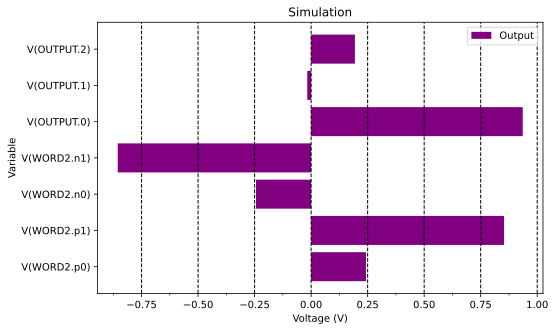

In [20]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

plt.figure(figsize=(8,5))

y = list(result['output_voltage'].values())
x = list(result['output_voltage'].keys())
plt.barh(x, y, label="Output", height=0.4*2, align='center', color='purple')

plt.title('Simulation')
plt.xlabel('Voltage (V)')
plt.ylabel('Variable')
plt.legend()

#plt.gca().xaxis.set_major_locator(MultipleLocator(interval))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.grid(which='major', axis='x', color='black', linestyle ='--', linewidth = 1)
plt.show()

### <mark>Cleanup</mark>

In [21]:
def delete_helper(thefile, debug=False):
    thedatetime =  __import__("datetime").datetime.now().strftime("%Y%m%d_%H%M")
    thefolder = "delete_" + thedatetime
    !mkdir -v -p {thefolder}
    if not debug:
        !mv {thefile} {thefolder}
    else:
        !ls {thefile}

# Cell
delete_helper(CELL_PARAMETERS['filename'] + ".asc")
delete_helper(CELL_PARAMETERS['filename'] + ".asy")
# CBA1
delete_helper(CBA1_PARAMETERS['filename'] + ".asc")
delete_helper(CBA1_PARAMETERS['filename'] + ".asy")
# CBA2
delete_helper(CBA2_PARAMETERS['filename'] + ".asc")
delete_helper(CBA2_PARAMETERS['filename'] + ".asy")
# NEU1
delete_helper(NEURON1_PARAMETERS['filename'] + ".asc")
delete_helper(NEURON1_PARAMETERS['filename'] + ".asy")
# NEU2
delete_helper(NEURON2_PARAMETERS['filename'] + ".asc")
delete_helper(NEURON2_PARAMETERS['filename'] + ".asy")
# Wrapper
delete_helper(WRAPPER_PARAMETERS['filename'] + ".asc")
# Simulation temporary files
delete_helper("*_tmp*")
delete_helper("*.net*")
# LTSpice temporary files
delete_helper("*.log *.plt *.raw")


mkdir: created directory 'delete_20230217_1142'
mv: cannot stat '*.log': No such file or directory
mv: cannot stat '*.plt': No such file or directory
mv: cannot stat '*.raw': No such file or directory


The End